In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [0]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
plays = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/user_artists.dat', sep='\t')
artists = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ml-scratch-posts/data/artists.dat', sep='\t', usecols=['id','name'])

# Preprocessing

In [0]:
ap = pd.merge(
  artists, plays, 
  how="inner",
  left_on="id",
  right_on="artistID"
)

In [0]:
ap = ap.rename(columns={"weight": "playCount"})

In [0]:
ap.head()

,id,name,userID,artistID,playCount
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [0]:
artist_rank = ap.groupby(['name']) \
  .agg({'userID' : 'count', 'playCount' : 'sum'}) \
  .rename(columns={"userID" : 'totalUniqueUsers', "playCount" : "totalArtistPlays"}) \
  .sort_values(['totalArtistPlays'], ascending=False)

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays'] / artist_rank['totalUniqueUsers']

In [0]:
ap = ap.join(artist_rank, on="name", how="inner") \
  .sort_values(['playCount'], ascending=False)

In [0]:
ap.head()

,id,name,userID,artistID,playCount,totalUniqueUsers,totalArtistPlays,avgUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148


# Exploration

In [0]:
def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette='Blues_r')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black', fontsize=12) 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()

In [0]:
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148


In [0]:
ap.head()

,id,name,userID,artistID,playCount,totalUniqueUsers,totalArtistPlays,avgUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148


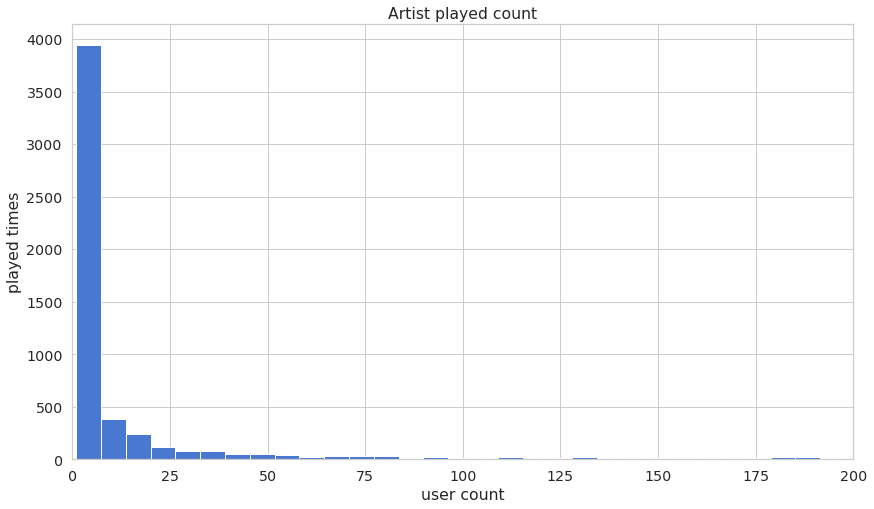

In [0]:
ax = ap.playCount.value_counts().hist(bins=100)
ax.set_xlim((0, 200))
ax.set_title("Artist played count")
ax.set_xlabel("user count")
ax.set_ylabel("played times");

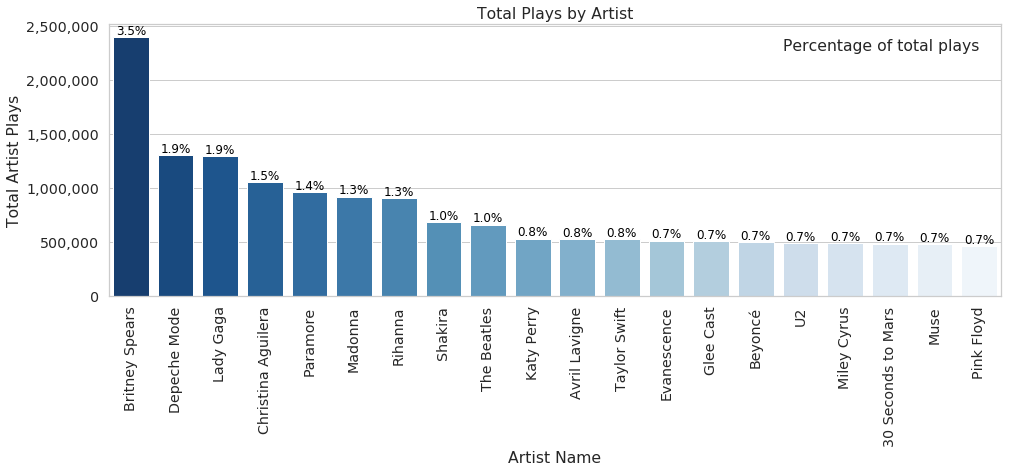

In [0]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentage of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

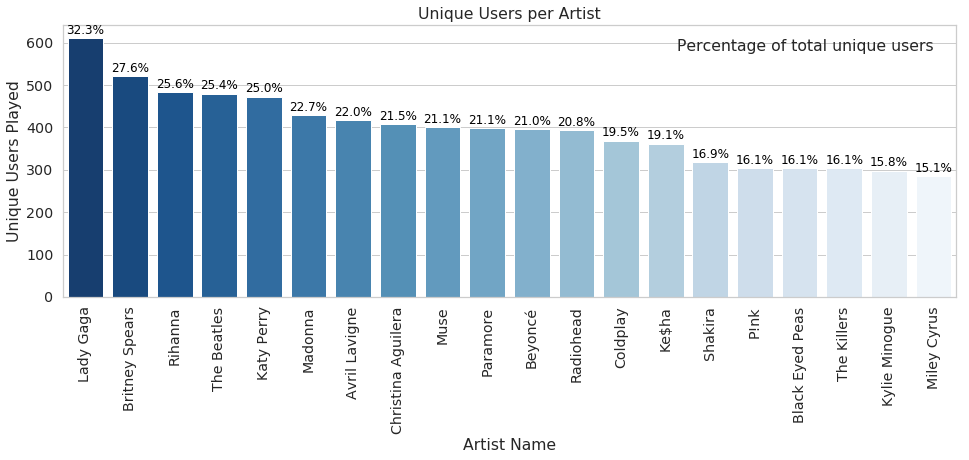

In [0]:
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentage of total unique users'
total_val = ap.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

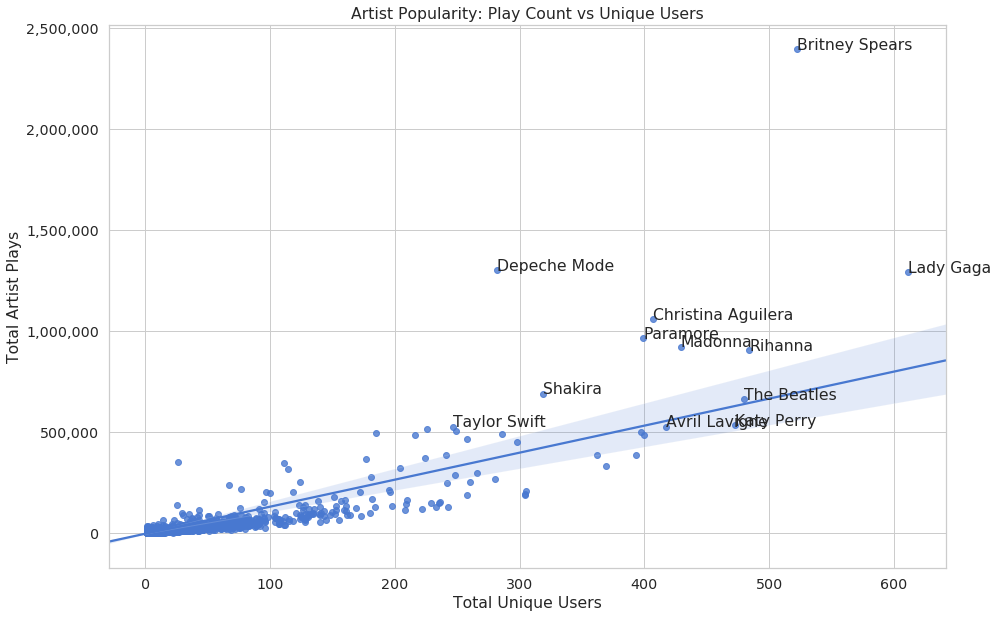

In [0]:

top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users')
ax.set_ylabel('Total Artist Plays')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

# Preprocessing

In [0]:
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

ap = ap.assign(playCountScaled=play_count_scaled)

In [0]:
ratings_df = ap.pivot(
    index='userID', 
    columns='artistID', 
    values='playCountScaled'
)

In [0]:
ratings = ratings_df.fillna(0).values

In [0]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [0]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [0]:
train, val = train_test_split(ratings)


In [0]:
train.shape

(1892, 17632)

In [0]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [0]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [0]:
recommender = Recommender().fit(train, val)

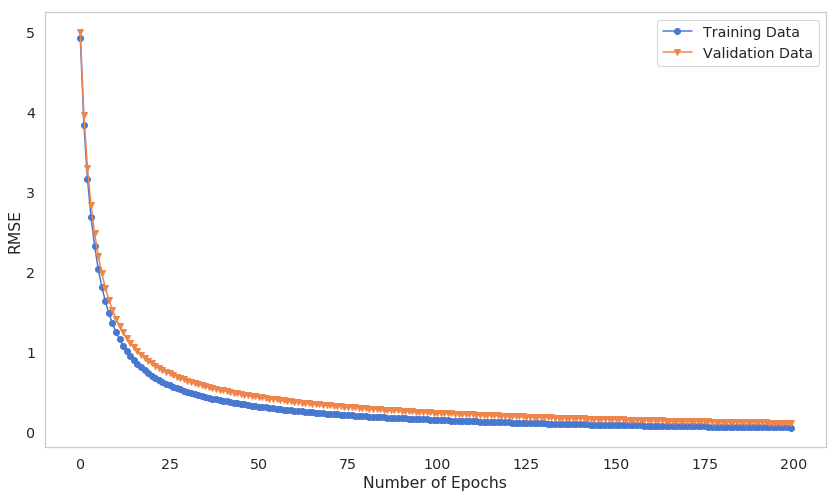

In [0]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

# Making recommendations

In [0]:
user_id = 1236
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [0]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
  artist_ids = ratings_df.columns[artists_index]
  artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
  top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
  artist_recommendations = artists_df[artists_df.id.isin(top_n_artists.artistId)].reset_index(drop=True)
  artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
  return artist_recommendations.sort_values("rating", ascending=False)

In [0]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(artists, existing_ratings_index, existing_ratings)

,id,name,rating
0,7,Marilyn Manson,0.196486
1,472,3 Doors Down,0.043204
2,614,Pearl Jam,0.042016
3,923,Children of Bodom,0.025657
4,978,Disturbed,0.021690
5,1104,Rammstein,0.021562
6,1118,A Perfect Circle,0.020879
7,2172,Gojira,0.017051
8,6257,Rob Zombie,0.016280
9,6618,D12,0.010990


In [0]:
create_artist_ratings(artists, predictions_index, rating_predictions)

,id,name,rating
0,1318,Sander van Doorn,0.559202
1,3167,Jacob Miller,0.552893
2,7627,Celtas Cortos,0.552142
3,10995,Camisa de Vênus,0.546361
4,12186,Ella Fitzgerald & Louis Armstrong,0.541477
5,12911,The Answer,0.537367
6,14245,Anjelika Akbar,0.536756
7,14940,Medications,0.536486
8,15792,Lützenkirchen,0.535515
9,18559,Archie Star,0.535147
